In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.utils import shuffle

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.stem import WordNetLemmatizer
import contractions

import warnings
warnings.filterwarnings('ignore')

In [2]:
# !pip install tensorflow==2.10.1

In [3]:
import tensorflow as tf

2023-03-06 16:15:58.767133: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
data = pd.read_json("datasets/dataset.json")
data.drop(['violation'], axis=1, inplace=True)


data = shuffle(data)

df = data[:8000]

test =  data[8001:9001]# pd.read_json("datasets/test_data.json")

In [5]:
df.head()

,text,hasBadWords
29988,<p>cute 19-year-old girl shows off her charms ...,False
30190,<h2>Milan Pizza Dough Squeeze</h2>\r\n<p>Milan...,False
40563,"BOOT DOMINATION, BOOT FETISH, SHINY CLOTHING, ...",False
43047,"HIGHLY ARCHED FEET, TOE POINTING, BIG FEET, WR...",False
71083,<center><a class='link' ><img src='http://stud...,False


In [6]:
df["hasBadWords"].value_counts()

False    7684
True      316
Name: hasBadWords, dtype: int64

<Axes: xlabel='count', ylabel='hasBadWords'>

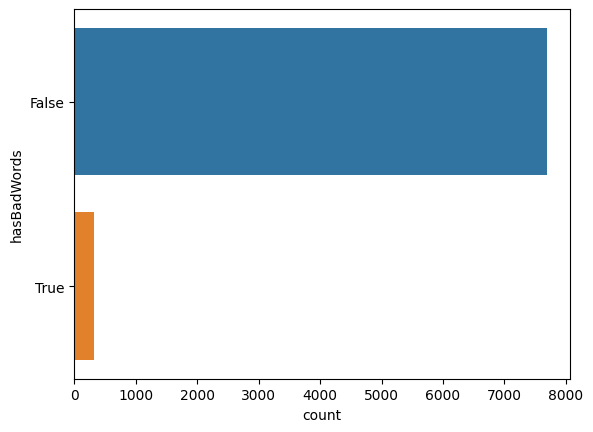

In [7]:
sns.countplot(y = df['hasBadWords'])

In [8]:
stop_word = set(stopwords.words("english"))

In [9]:
punt = punctuation.replace("!","").replace("?","")

In [10]:
def text_tokenize(text):
    tokenizer = word_tokenize(text, language='english', preserve_line=False)
    lemmatizer = WordNetLemmatizer()
    tokens = tokenizer #.tokenize(contractions.fix(text))
    
    pruned = []
    
    for token in tokens:
        if token not in punctuation and not token.startswith("http"):
            if token.startswith("@"):
                token = token.replace("@","")
                pruned.append(lemmatizer.lemmatize(token.lower()))

            else:
                
                pruned.append(lemmatizer.lemmatize(token.lower()))
            
    return pruned
clean_text = df["text"].apply(lambda x: text_tokenize(x))
clean_text.head()

29988    [p, cute, 19-year-old, girl, show, off, her, c...
30190    [h2, milan, pizza, dough, squeeze, /h2, p, mil...
40563    [boot, domination, boot, fetish, shiny, clothi...
43047    [highly, arched, foot, toe, pointing, big, foo...
71083    [center, a, class='link, img, src='http, //stu...
Name: text, dtype: object

In [11]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(clean_text, df["hasBadWords"], test_size=0.3, random_state=2023, stratify=df["hasBadWords"])
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((5600,), (2400,), (5600,), (2400,))

In [12]:
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer

In [13]:
# Reshape column 
y_train = y_train.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

In [14]:
one_hot_encode = OneHotEncoder(sparse_output=False)

In [15]:
y_train = one_hot_encode.fit_transform(y_train)
y_test = one_hot_encode.transform(y_test)

In [16]:
X_train = X_train.to_list()
X_test = X_test.to_list()

tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

max_input_length = np.max([len(x) for x in X_train])

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding= "post", maxlen = max_input_length)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding= "post", maxlen = max_input_length)


# Import LSTM**

In [17]:
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, SpatialDropout1D
from tensorflow.keras.utils import to_categorical

In [18]:
max_vocab = len(tokenizer.word_index) + 1
input_data = Input((max_input_length,), name= "input_layer")
embedding_output = Embedding(max_vocab, 100, mask_zero = True, name = "embedding_layer")(input_data)

2023-03-06 16:16:22.023675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
dropout = SpatialDropout1D(0.5, name = "dropout_layer")(embedding_output)
lstm_output = Bidirectional(LSTM(100, dropout = 0.5, recurrent_dropout = 0.2, return_state = False, 
                                name = "lstm_layer"))(dropout)
output_data = Dense(2, activation = "softmax")(lstm_output)

In [20]:
lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=50, decay_rate=0.9, staircase=False)

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.weight_decay(tf.float32)
    return lr

optimizer = tf.keras.optimizers.Adam(learning_rate = lr)

lr_metric = get_lr_metric(optimizer)

model = tf.keras.Model(input_data, output_data)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 2563)]            0         
                                                                 
 embedding_layer (Embedding)  (None, 2563, 100)        2146300   
                                                                 
 dropout_layer (SpatialDropo  (None, 2563, 100)        0         
 ut1D)                                                           
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                                 
Total params: 2,307,502
Trainable params: 2,307,502
Non-train

In [ ]:
model.fit(X_train, y_train, batch_size = 512, epochs = 4, validation_data = (X_test, y_test))

Epoch 1/4
 1/11 [=>............................] - ETA: 27:36 - loss: 0.6943 - accuracy: 0.4844

In [ ]:
model.save('models/lstm.model')

In [ ]:
test.head()

In [ ]:
# normalize and toknize to test data
text = test["text"]
text = text.apply(lambda x : text_tokenize(x))
text = text.to_list()
text = tokenizer.texts_to_sequences(text)
text = tf.keras.preprocessing.sequence.pad_sequences(text, padding = "post", maxlen = max_input_length)

In [ ]:
text

In [ ]:
# predictions 
pred = model.predict(text)
hasBadWords = one_hot_encode.inverse_transform(pred)
test["Prediction"] = hasBadWords

In [ ]:
test.head()

In [ ]:
accuracy = np.sum(test["hasBadWords"] == test["Prediction"]) / len(test)
print("accuracy = {}".format(accuracy))

In [ ]:
# Wrong prediction 
(test[test["hasBadWords"] != test["Prediction"]]).count()